In [1]:
""" NARMA2 inspired input """
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np
import json
import util

torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)



In [4]:
Two,Ttrain = 2000,100000

N = 10
C = 0
rho = 0.6
sigma = 1.0
dim = 1
N_d = int(N * dim)
idWin = False
actf = "tanh"
rseed=0



fn = "nl_timeCorr_narma2"
## store setting
setting = {"input dim":dim,"Two":Two, "Ttrain":Ttrain,"sigma":sigma,"rseed" : rseed, 
            "Nodes":N_d,"uC":C,"rho":rho, "actf":actf,"identical Win":idWin,"input dist":"narma2 inspired"}

print("settings stored:",setting)

settings stored: {'input dim': 1, 'Two': 2000, 'Ttrain': 100000, 'sigma': 1.0, 'rseed': 0, 'Nodes': 10, 'uC': 0, 'rho': 0.6, 'actf': 'tanh', 'identical Win': False, 'input dist': 'narma2 inspired'}


In [4]:
## Create and store input
fn_in = "10N_100K"
x_t = torch.load('./experiments/inputs/'+fn_in+'_i.pt')

/tmp/ipykernel_195382/816553917.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_t = torch.load('./experiments/inputs/'+fn_in+'_i.pt')


In [128]:
u = torch.zeros((1,Two+Ttrain))
u_1 = torch.zeros(Two+Ttrain)
u_2 = torch.zeros(Two+Ttrain)
u_3 = torch.zeros(Two+Ttrain)


for t in range(Two+Ttrain):
#for t in range(Two+Ttrain-5000,Two+Ttrain):
    u_1[t] = 0.6*u[0][t-1] 
    u_2[t] = 3*u[0][t-1]*u[0][t-2]
    u_3[t] = 0.01*x_t[0][t]
    u[0][t]= u_1[t]+u_2[t]+u_3[t] 


tensor(0.0003, device='cuda:0')


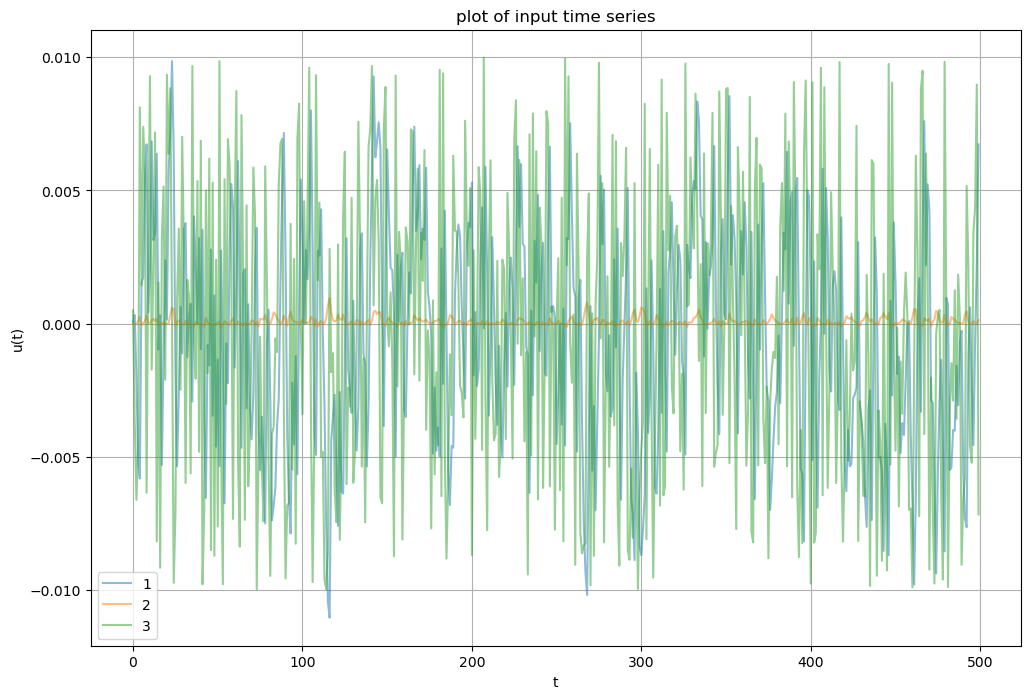

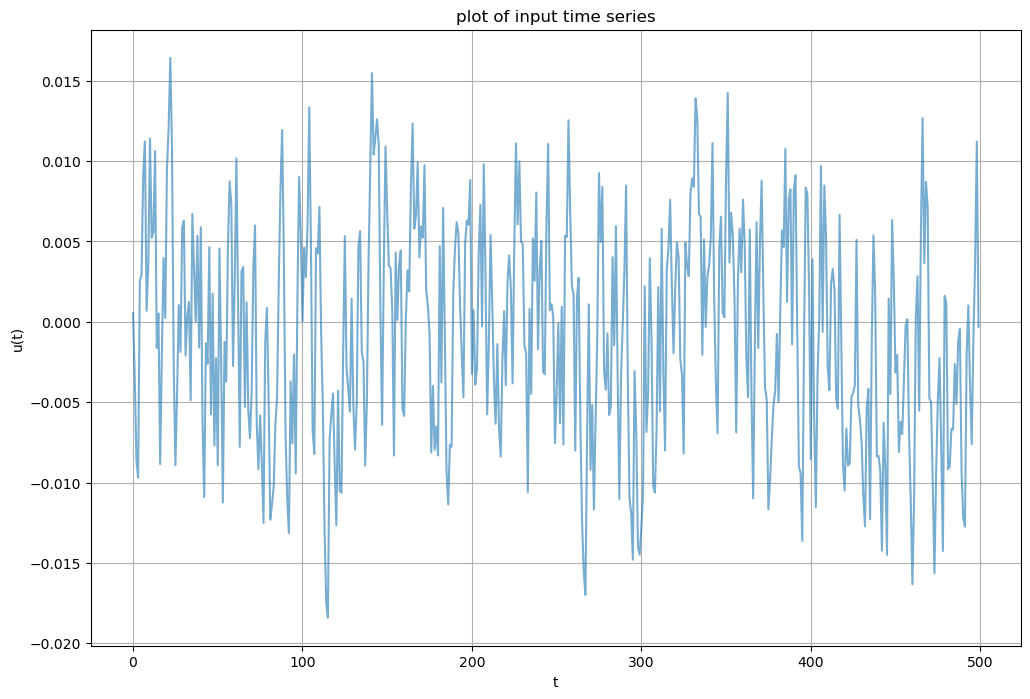

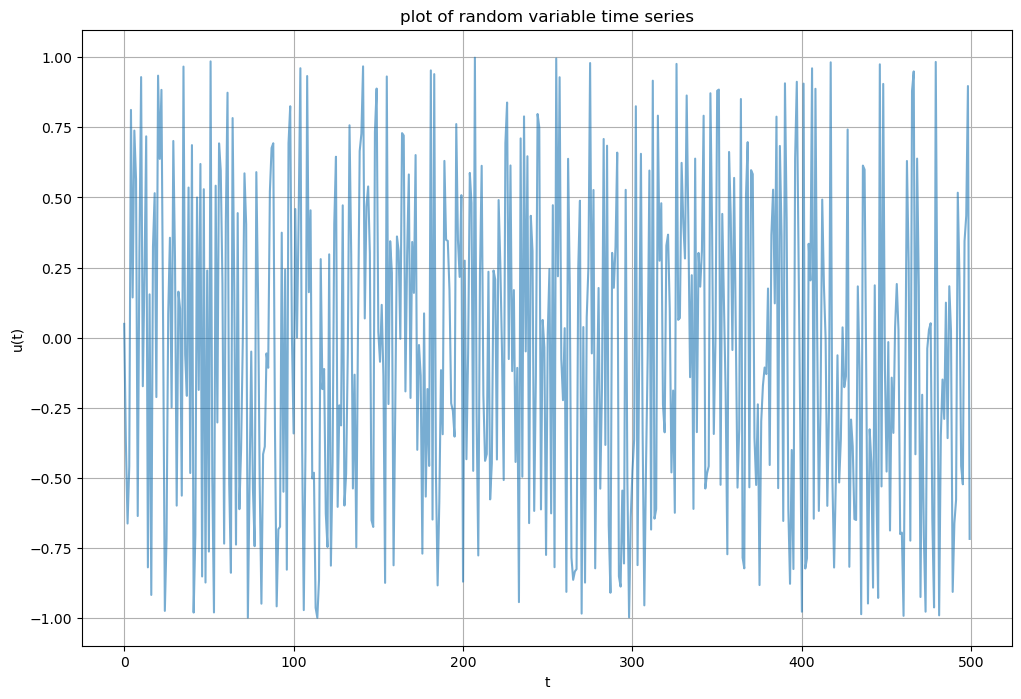

In [129]:
maxT=500
alp = 0.5   

fig,ax = plt.subplots(figsize=(12,8))
t=np.arange(maxT)
for d in range(dim):
    plt.plot(t,u_1[-maxT:].cpu().numpy(),alpha=alp,label="1")
    plt.plot(t,u_2[-maxT:].cpu().numpy(),alpha=alp,label="2")
    plt.plot(t,u_3[-maxT:].cpu().numpy(),alpha=alp,label="3")

print(torch.mean(u))
    
plt.xlabel("t")
plt.ylabel(r'u(t)')
plt.title(r'plot of input time series')
plt.legend()
plt.grid(True)
plt.show()



maxT=500
fig,ax = plt.subplots(figsize=(12,8))
t=np.arange(maxT)
for d in range(dim):
    plt.plot(t,u[d][-maxT:].cpu().numpy(),alpha=0.6,label="dim "+str(d))
plt.xlabel("t")
plt.ylabel(r'u(t)')
plt.title(r'plot of input time series')
#plt.legend()
plt.grid(True)
plt.show()


fig,ax = plt.subplots(figsize=(12,8))
t=np.arange(maxT)
for d in range(dim):
    plt.plot(t,x_t[d][-maxT:].cpu().numpy(),alpha=0.6,label="dim "+str(d))
plt.xlabel("t")
plt.ylabel(r'u(t)')
plt.title(r'plot of random variable time series')
#plt.legend()
plt.grid(True)

In [2]:
## Create and store input
fn = "nl_timeCorr_narma2"
u = torch.load('./experiments/inputs/'+fn+'_i.pt',weights_only=False)
print(torch.mean(u))
u = u - torch.mean(u)

/tmp/ipykernel_236623/383425222.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  u = torch.load('./experiments/inputs/'+fn+'_i.pt')


tensor(8.4899e-19, device='cuda:0')


In [5]:
""" temp """

esn = ESN.ESN_mult(N_d, uC=C, rho=rho, dim=dim,rseed=0,idWin=idWin)

print("start runnig")
st = time.time()
Xwo = esn.run_washout(u, Two, actf=actf,bias=False)
print("runtime :",time.time()-st)



start runnig
runtime : 15.049941301345825


In [131]:
## make targets
maxdd=[[1,20],
       [2,10],
       [3,10],
       [4,7],
       [5,7],
       [6,3],
       [7,3]]


st = time.time()
tar_naive = ESN.make_targets(u=u,maxddsets=maxdd,Two=Two)
print(r"target creation time:%.3f s"%(time.time()-st))


basis table creation:0.001 s
1 degree:20 target functions
2 degree:55 target functions
3 degree:220 target functions
4 degree:210 target functions
5 degree:462 target functions
6 degree:28 target functions
7 degree:36 target functions
Total of 1031 bases
 7/7 degree bases now calculating ...
target creation complete, total of 1031 bases
target creation time:1.029 s


In [7]:
#
tar_tilde = torch.load(f"./experiments/target_info/{fn_in}_ti.pt")
#torch.save(tar_tilde,f"./experiments/target_info/{fn}_ti.pt")

/tmp/ipykernel_236623/960827596.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tar_tilde = torch.load(f"./experiments/target_info/{fn_in}_ti.pt")


In [ ]:

torch.save(tar_tilde,f"./experiments/target_info/{fn}_tilde_ti.pt")
torch.save(ipc,f"./experiments/ipcs/{fn}_ipc.pt")

In [9]:
"""  temp  """
st = time.time()
raw_tilde,thr_tilde,thr_scl_tilde,rev_tilde,sur_tilde = ESN.calc_capacity(Xwo,tar_tilde.tar_f,ret_all=True,thr_scale=1.2)
print(r"ipc calc time :%.3f s"%(time.time()-st))
print(sur_tilde)
ipc_tilde = ESN.IPC_w_targetinfo(thr_scl_tilde,tar_tilde)
util.print_ipc(ipc_tilde)

ipc calc time :0.095 s
tensor(9.9588e-05, device='cuda:0')
1 deg ipc: 9.977366739729861
2 deg ipc: 0.006527322584270685
3 deg ipc: 0.017279064869524616
4 deg ipc: 0.0
5 deg ipc: 0.00025656889633973165
6 deg ipc: 0.0
7 deg ipc: 0.0
total ipc: 10.001429696079997


In [ ]:
"""  temp  """
st = time.time()
raw,thr,thr_scl,rev,sur = ESN.calc_capacity(Xwo,tar_naive.tar_f,ret_all=True,thr_scale=1.2,mean_normalization=True)
print(r"ipc calc time :%.3f s"%(time.time()-st))
print(sur)
ipc_naive = ESN.IPC_w_targetinfo(raw,tar_naive)
util.print_ipc(ipc_naive)

RESULT FOR NORMALIZED IPC


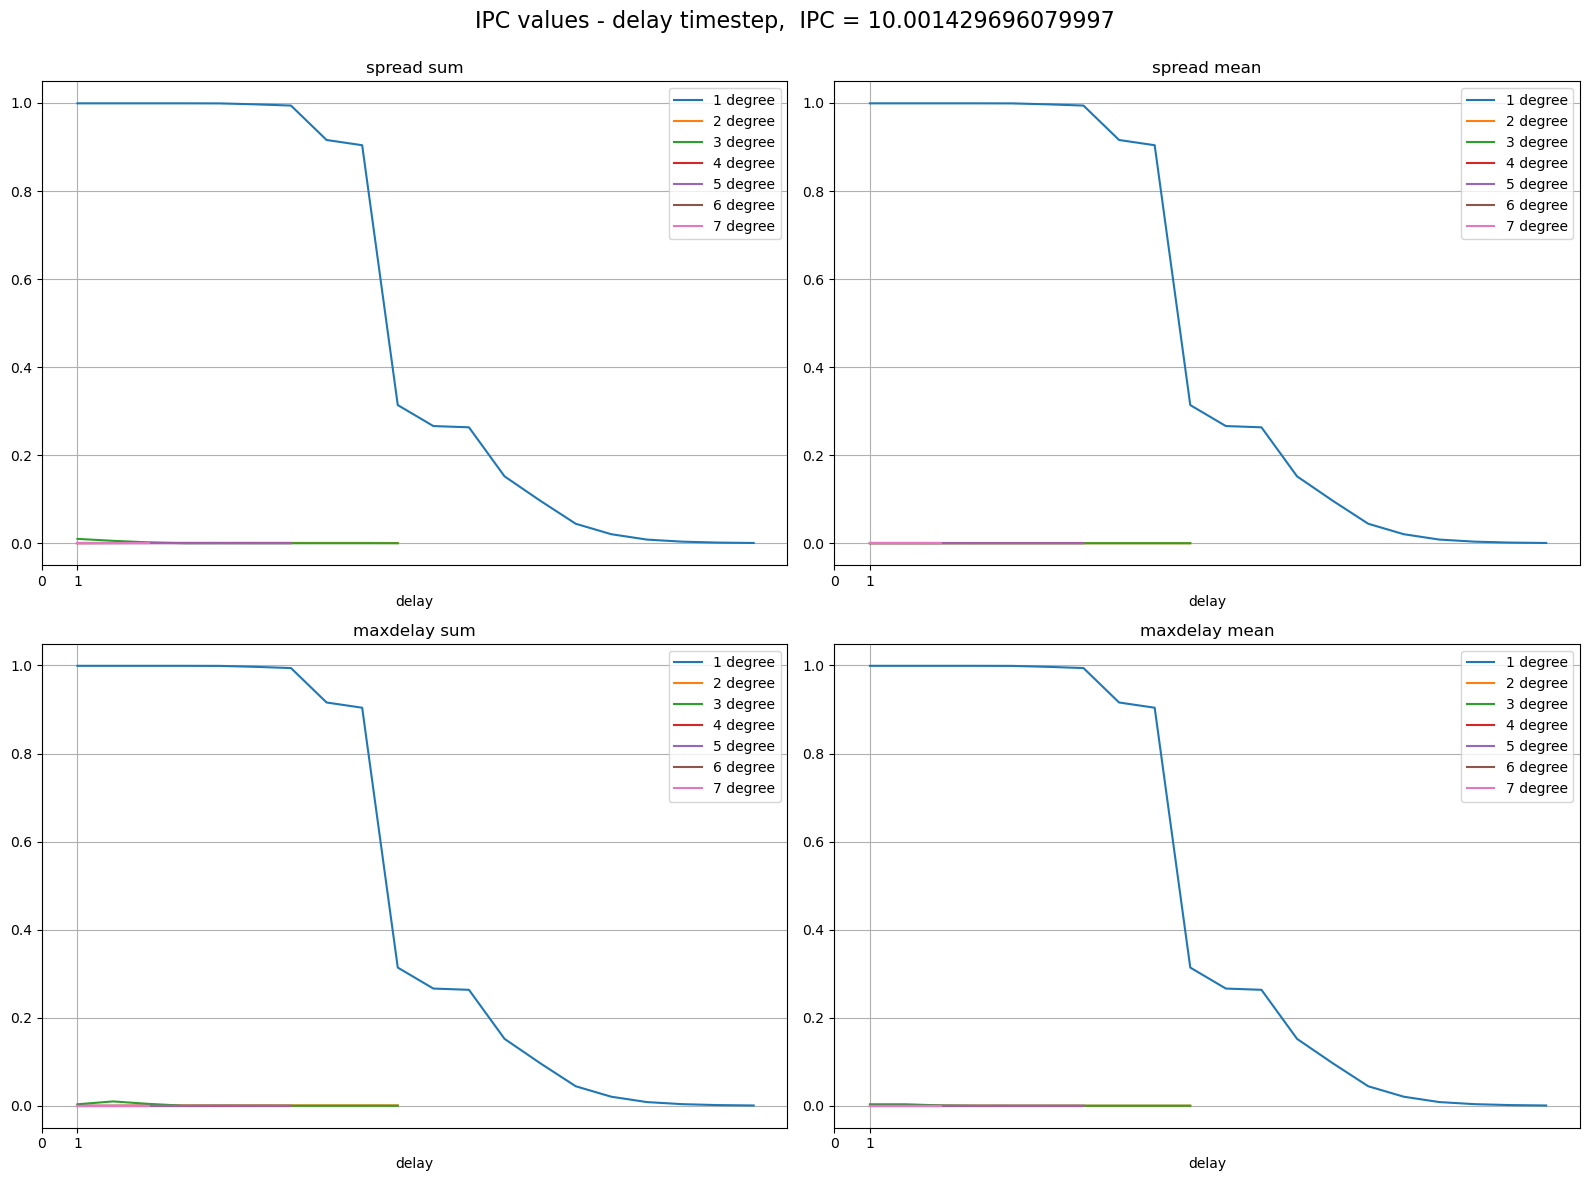

In [10]:
print("RESULT FOR NORMALIZED IPC")
util.ipc_tau_plot(ipc_tilde)
#print("RESULT FOR NAIVE IPC")
#util.ipc_tau_plot(ipc_naive)

